# Creating a variational classifier with PennyLane

In the guest lecture on quantum kernels, we saw in Section 4 that feature embeddings can be used in combination with variational classifiers that analyse data in "quantum feature space". This notebook shows a simplified implementation of the idea in the PennyLane framework for hybrid optimization. 

Since training variational quantum circuits can be time consuming, we show what decision boundaries for a simple classification task a quantum classifier gives rise to.

### The variational circuit

The circuit we discussed contains the following elements:
1. a quantum circuit $S_x$ that depends on an input $x$, which maps the input to a quantum state,
2. a variational circuit $U_{\theta}$, which depends on parameters $\theta$ that can be optimized,
3. a computational basis measurement of the first qubit. 

The routine can be interpreted as a classifier that takes inputs $x$ and maps them to outputs $y = \langle \hat{\sigma}_z\rangle$. The classifier is "trained" by finding parameters $\theta$ given data of input-output samples.

<img src="variational_classifier.png" alt="circuit" style="width:400px;"/>

For this tutorial to run, you need to install the PennyLane library. In most cases this can be done with 

    pip install pennylane 

**An extended example and more details can be found at *pennylane.ai*.**

### Importing libraries

Let us import some helpers from scikit-learn:

In [1]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

If you installed the PennyLane library correctly, you can run the following imports.

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import GradientDescentOptimizer

We also need matplotlib for visualisation. 

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline  

### Implementing the circuit

As a quantum device we use PennyLane's default qubit simulator with 2 qubits. We can create the quantum device as follows. 

*Note 1: using another backend than `default.qubit`, we can also run the circuit on a real quantum device through a cloud service.*

*Note 2: the keyword `wires` stands for the number of qubits. Since PennyLane can also handle non-qubit (i.e., continuous-variable systems), wires generally refers to the number of subsystems.*

In [4]:
dev = qml.device('default.qubit', wires=2)

We now implement the two quantum circuits in PennyLane, using rather arbitrary gate sequences (find better ones!). Let is first define a feature embedding (or state preparation) circuit $S_x$...

In [5]:
def S(x): 
    qml.RX(x[0], 0)
    qml.RX(x[1], 1)

... and a classification circuit $U(\theta)$.

In [6]:
def U(theta):  
    qml.Rot(theta[0], theta[1], theta[2], 0)
    qml.Rot(theta[3], theta[4], theta[5], 0)
    qml.CNOT([1, 0])

We call these two routines in a quantum classifier function. In fact, $U(\theta)$ is called several times, depending on how many lists of parameters `thetas` contains. After this, the expectation of the Pauli Z operator is measured with respect to the final state. 

The line "@qml.qnode(dev)" is a *decorator* that turns the function into a QNode object, PennyLane's representation of quantum computations. Note that in `qclassifier` no classical processing (e.g., addition, multiplication, etc) is allowed, but only quantum information processing (gates and expectation values). You can find more information on https://pennylane.readthedocs.io/en/latest/code/qnode.html .

In [7]:
num_layers = 3

@qml.qnode(dev)
def qclassifier(thetas, x=None):
    S(x)
    for theta in thetas:
        U(theta)
    return qml.expval.PauliZ(0)

For optimization we need a cost function. The cost compares targets Y and model outputs with a square loss function. PennyLane needs to be able to "pass gradients" through these functions, which is ensured by previously importing PennyLane's native numpy library version as `np`. (This import makes most numpy operations accessible to automatic differentiation; in other words, PennyLane can compute gradients of functions constructed from QNodes and numpy operations).

In [8]:
def cost(theta, X, Y):
    Y_ = np.array([qclassifier(theta, x=x) for x in X])
    loss = np.mean(np.abs(Y - Y_)**2)
    return loss 

### Loading data

We generate a simple dataset of two features. To simplify things we will not split it into training and validation sets but just try to fit the data.

In [9]:
X, y = make_classification(n_samples=30, n_features=2, n_informative=2, n_redundant=0, 
                           n_repeated=0, n_classes=2, random_state=6, class_sep=1.4)

We can visualise the data with matplotlib.

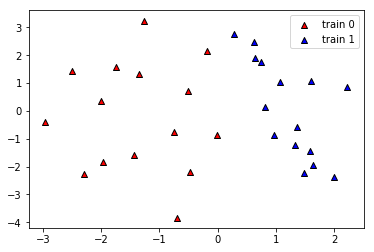

In [10]:
plt.figure()
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], c='r', marker='^', edgecolors='k', label="train 0")
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], c='b', marker='^', edgecolors='k', label="train 1")
plt.legend()
plt.show()

### Visualising the decision boundary

Let's have a look at the decision boundaries that the quantum classifier "naturally" gives rise to if it is not trained.

You can change the parameter `num_layers` above and run its cell again to play around with the shape of the decision boundary. (The parameter is defined in the same cell as the `qclassifier` in order to make sure you redefine the classifier as well once `num_layers` changes.)

*PS: The plot takes some seconds to be built.*

In [11]:
np.random.seed(10)
thetas = 3*np.random.rand(num_layers, 6)

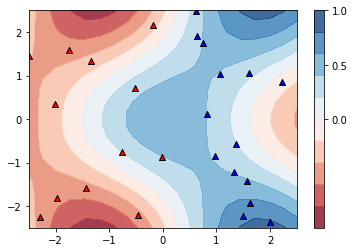

In [12]:
# make data grid for contour plot
xx, yy = np.meshgrid(np.linspace(-2.5, 2.5, 20), np.linspace(-2.5, 2.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# plot decision regions
plt.figure()
cm = plt.cm.RdBu
predictions_grid = [qclassifier(thetas, x=x) for x in X_grid]
Z = np.reshape(predictions_grid, xx.shape)
cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.2), cmap=cm, alpha=.8)
plt.colorbar(cnt, ticks=[0, 0.5, 1])

# plot data
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], c='r', marker='^', edgecolors='k', label="train 0")
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], c='b', marker='^', edgecolors='k', label="train 1")

plt.ylim(-2.5, 2.5)
plt.xlim(-2.5, 2.5)
plt.show()

# Training

The model can be trained by updating the parameters with stochastic gradient descent. In each step, a fair bit of quantum computation is simulated in the background to get gradients for each data point, and training takes some time. 

In [13]:
o = GradientDescentOptimizer(0.01)

for it in range(40):
    
    thetas = o.step(lambda v: cost(v, X, y), thetas)
    print("Cost in step" , it+1 , ":", cost(thetas, X, y))

Cost in step 1 : 0.34446044359858236
Cost in step 2 : 0.33999997005941457
Cost in step 3 : 0.33581915712613963
Cost in step 4 : 0.33189645895663944
Cost in step 5 : 0.3282121232717326
Cost in step 6 : 0.32474804269681345
Cost in step 7 : 0.32148761639468854
Cost in step 8 : 0.31841562188225087
Cost in step 9 : 0.315518096738261
Cost in step 10 : 0.3127822297831682
Cost in step 11 : 0.31019626123081806
Cost in step 12 : 0.3077493912650728
Cost in step 13 : 0.3054316964730793
Cost in step 14 : 0.3032340535643096
Cost in step 15 : 0.30114806981522346
Cost in step 16 : 0.29916601969935314
Cost in step 17 : 0.29728078718865664
Cost in step 18 : 0.29548581324173284
Cost in step 19 : 0.29377504802618853
Cost in step 20 : 0.29214290745482835
Cost in step 21 : 0.2905842336473982
Cost in step 22 : 0.2890942589608088
Cost in step 23 : 0.28766857326056183
Cost in step 24 : 0.28630309413429955
Cost in step 25 : 0.28499403977478893
Cost in step 26 : 0.2837379042842136
Cost in step 27 : 0.28253143517

Finally, we can evaulate the accuracy on the training set, comparing model predictions with the target labels `y`. If the accuracy is `1.0`, all data points have been classified correctly by the model. Of course, this does not tell us anything about the model's generalisation performance.

*You can run the cell above again to train for another 40 steps.*

In [14]:
pred = [1 if qclassifier(thetas, x=x_) > 0 else 0 for x_ in X]
accuracy_score(pred, y)

0.9

Let's plot the new decision regions.

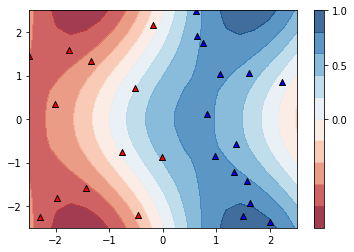

In [15]:
# make data for plot
xx, yy = np.meshgrid(np.linspace(-2.5, 2.5, 20), np.linspace(-2.5, 2.5, 20))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# start plot
plt.figure()
cm = plt.cm.RdBu

# plot decision regions
predictions_grid = [qclassifier(thetas, x=x) for x in X_grid]
Z = np.reshape(predictions_grid, xx.shape)
cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1, 0.2), cmap=cm, alpha=.8)
plt.colorbar(cnt, ticks=[0, 0.5, 1])

# plot data
plt.scatter(X[:, 0][y==0], X[:, 1][y==0], c='r', marker='^', edgecolors='k', label="train 0")
plt.scatter(X[:, 0][y==1], X[:, 1][y==1], c='b', marker='^', edgecolors='k', label="train 1")

plt.ylim(-2.5, 2.5)
plt.xlim(-2.5, 2.5)
plt.show()